In [1]:
import numpy as np 

import scipy as sp
import scipy.linalg as la
import scipy.integrate
from scipy.integrate import odeint
from scipy.linalg import eigh   #返回复数Hermitian(共轭对称)或实对称矩阵的特征值和特征向量

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei']  #正常显示title的中文，但是仅仅坐标轴不需要这句话
plt.rcParams['axes.unicode_minus']=False    #title显示中文后 正负号无法显示，此为修复语句

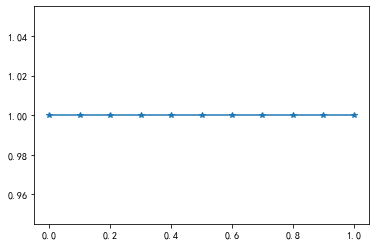

In [2]:
L = 1
num = 10
num_elems = num+1
x = np.linspace(0,L,num_elems) #一米的梁分成十份  #x.shape # =11

ini_shape= [ 1 for i in range(num_elems) ]
plt.plot(x,ini_shape,marker='*')

In [3]:
l = x[1]-x[0]   #m kg Pa  | mm kg MPa
E = 2*10**5  #pa
u = 0.3
I = 763*10**-8
Rho = 1000  # 

c = 0.2
q = 100

k = (E*I/l**3)*np.array([ [12,6*l,-12,6*l],
                          [6*l,4*l**2,-6*l,2*l**2],
                          [-12,-6*l,12,-6*l],
                          [6*l,2*l**2,-6*l,4*l**2] ])
m = (Rho*l/420)* np.array([ [156,22*l,54,-13*l],
                            [22*l,4*l**2,13*l,-3*l**2],
                            [54,13*l,156,-22*l],
                            [-13*l,-3*l**2,-22*l,4*l**2] ])
c = m*(c/Rho)
f = np.array([0.5*q*l,0,0.5*q*l,0])

In [4]:
def beam_matrx_add(num_elems):
    M = np.zeros((2*num_elems+2,2*num_elems+2))
    K = np.zeros((2*num_elems+2,2*num_elems+2))
    C = np.zeros((2*num_elems+2,2*num_elems+2))
    F = np.zeros(2*num_elems+2)
    
    for i in range(num_elems):
        M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        C_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        F_temp = np.zeros(2*num_elems+2)
        M_temp[2*i:2*i+4, 2*i:2*i+4] = m    #切片赋值 
        K_temp[2*i:2*i+4, 2*i:2*i+4] = k    #Slice assignment
        C_temp[2*i:2*i+4, 2*i:2*i+4] = c
        F_temp[2*i:2*i+4] = f
        M += M_temp
        K += K_temp
        C += C_temp
        F += F_temp
        
    M_end = M[2:,2:]    #删去 固定端约束自由度 前两行 前两列
    K_end = K[2:,2:]
    C_end = C[2:,2:]
    F_end = F[2:]
    return M_end , K_end ,C_end ,F_end , F

M , K , C , F_end , F = beam_matrx_add( num_elems )

In [5]:
omega_2, fai = eigh(K,M)    #返回复数Hermitian(共轭对称)或实对称矩阵的特征值[已排序]和特征向量
omega = np.sqrt(omega_2)    # omega.shape # = 22
#fai.shape #(22, 22)

# #明显对角矩阵
# qqq = fai.T @ K @ fai # qqq[np.where(qqq<10**-11)]=0
# fai.T @ C @ fai #

Text(0.5, 1.0, ' Vibration shape: angle ')

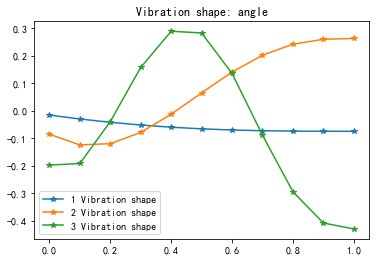

In [6]:
plt.plot(x,fai[1:22:2,0],label="1 Vibration shape",marker='*')
plt.plot(x,-fai[1:22:2,1],label="2 Vibration shape",marker='*')
plt.plot(x,fai[1:22:2,2],label="3 Vibration shape",marker='*')
plt.legend()
plt.title(" Vibration shape: angle ")

Text(0.5, 1.0, ' Vibration shape: Longitudinal displacement  ')

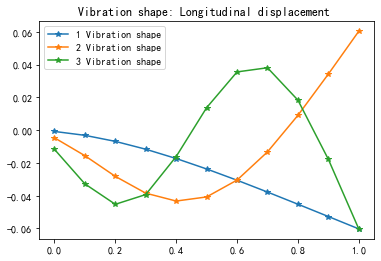

In [7]:
plt.plot(x,fai[::2,0],label="1 Vibration shape",marker='*')
plt.plot(x,-fai[::2,1],label="2 Vibration shape",marker='*')
plt.plot(x,fai[::2,2],label="3 Vibration shape",marker='*')
plt.legend()
plt.title(" Vibration shape: Longitudinal displacement  ")

Text(0.5, 1.0, 'Analytical solution')

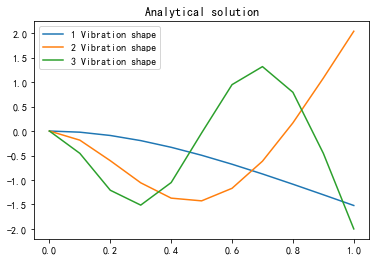

In [8]:
def static(i,x):
    beta_i = (2*i-1)*np.pi / (2*L)
    kexi_i = - ( np.cos(beta_i*L)+np.cosh(beta_i*L) ) / ( np.sin(beta_i*L)+np.sinh(beta_i*L) )
    fai_i = np.cos(beta_i*x) - np.cosh(beta_i*x) + kexi_i*(np.sin(beta_i*x)-np.sinh(beta_i*x))
    return fai_i
for i in range(1,4):
    plt.plot(x,static(i,x),label="{} Vibration shape".format(i))
    plt.legend()
plt.title("Analytical solution")

(101, 22)

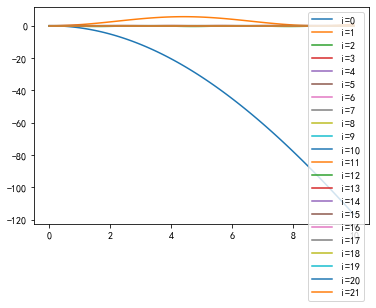

In [9]:
result = np.zeros( (101,len(omega)) )
for i in range(len(omega)):
    Mit = (fai[:,i].T) @ M @ fai[:,i] #;print("mit=",Mit)
    Kit = (fai[:,i].T) @ K @ fai[:,i] #;print("Kit=",Kit)
    Cit = (fai[:,i].T) @ C @ fai[:,i] #;print("Cit=",Cit)
    Fit = fai[: ,i].T  @ F_end        #;print("f=",Fit)

    def diff(y,t):
        yt, theta = y
        return theta , (Fit-Kit*yt-Cit*theta) / Mit

    y0 = [0,0]
    t = np.linspace(0, 10, 101)
    sol = odeint(diff, y0, t) 
    result[:,i] += sol[:,0]
    plt.plot(t,sol[:,0],label='i={}'.format(i) )
    plt.legend()
result.shape

In [10]:
x_result = np.zeros((22,101))
# fai[:,1].reshape(-1,1)
# aaa =fai[:,1].reshape(-1,1) @ (result[:,1].reshape(1,101)) #20X101矩阵 #在进行矩阵乘法前一定要先reshape  尤其是 列 乘 行 的这种

for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 
x_result.shape #22X101矩阵

(22, 101)

Text(0.5, 0.92, 'displacement: u')

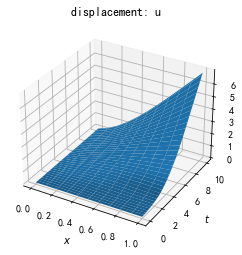

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid(x,t)
ax.plot_surface(X,T,x_result[::2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_title('displacement: Longitudinal displacement')

Text(0.5, 0.92, 'Angle change')

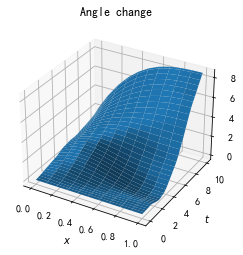

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid(x,t)
ax.plot_surface(X,T,x_result[1:22:2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_title('Angle change')


In [23]:
# for i in range(len(omega) ):
#     plt.plot(t,x_result[i,:],label='i={}'.format(i) )
#     plt.legend()